# Q function calculation in QuTiP
Gengyan Zhang, Dec 04 2015

To run the notebook, place the file [myqfunc.py](./myqfunc.py) in the same folder.

In [1]:
%matplotlib inline
import IPython
IPython.display.set_matplotlib_formats('png', 'pdf')
from scipy.misc import factorial
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import myqfunc

## QuTiP method
The Husimi Q function for a state $\rho$ is defined as $Q(\alpha) = \dfrac{1}{\pi}\langle\alpha|\rho|\alpha\rangle$.

In QuTip, the source code that calculates the Q function for a pure state $\psi=(\psi_0,\cdots,\psi_n)$ is

```python
def _qfunc_pure(psi, alpha_mat):

"""
Calculate the Q-function for a pure state.
"""
n = np.prod(psi.shape)
if isinstance(psi, Qobj):
    psi = psi.full().flatten()
else:
    psi = psi.T

qmat = abs(polyval(fliplr([psi / sqrt(factorial(arange(n)))])[0],
                   conjugate(alpha_mat))) ** 2

return real(qmat) * exp(-abs(alpha_mat) ** 2) / pi
```
For each $\alpha$, it calculates $\displaystyle Q(\alpha)=\left|\sum_{m=0}^n \frac{(\alpha^*)^m}{\sqrt{m!}}\psi_m\right|^2\frac{\exp(-|\alpha|^2)}{\pi}$ directly.

The problem is it uses scipy.misc.factorial to calculate $m!$, and it gives infinity when $m > 170$.

In [2]:
[factorial(170), factorial(171)]

[array(7.257415615308e+306), array(inf)]

So for a coherent state $|\alpha\rangle$ with $|\alpha|^2> 170$, The Q function becomes inaccurate.

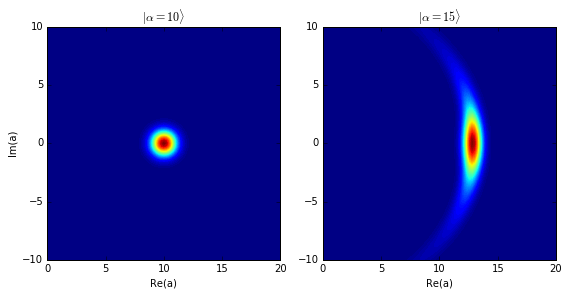

In [3]:
N = 300 # Dimension of Hilbert space
psi1 = qt.coherent(N, 10) # Coherent state |alpha=10>
psi2 = qt.coherent(N, 15) # Coherent state |alpha=15>
areal = np.linspace(0, 20, 101) # Grid for real part of alpha
aimag = np.linspace(-10, 10, 101) # Grid for imaginary part of alpha
Q1 = qt.qfunc(psi1, areal, aimag, 2) # Q function for psi1
Q2 = qt.qfunc(psi2, areal, aimag, 2) # Q function for psi2

# Plot results
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121)
plt.contourf(areal, aimag, Q1, 100)
ax1.set_aspect('equal')
plt.xlabel('Re(a)')
plt.ylabel('Im(a)')
plt.title(r'$|\alpha=10\rangle$')

ax2 = plt.subplot(122)
plt.contourf(areal, aimag, Q2, 100)
ax2.set_aspect('equal')
plt.xlabel('Re(a)')
plt.title(r'$|\alpha=15\rangle$')
plt.tight_layout()

## Modified method
To fix this, we use Stirling's approximation $n!\approx\sqrt{2\pi n}\left(\dfrac{n}{e}\right)^n$, so

$\displaystyle Q(\alpha) = \frac{1}{\pi}\left|\sum_{m=0}^{n_0}\exp\left(-\frac{|\alpha|^2}{2}\right)\frac{(\alpha^*)^m}{\sqrt{m!}}\psi_m+\sum_{m=n_0+1}^n \exp\left(-\frac{|\alpha|^2-m}{2}\right)(2\pi m)^{-1/4}\left(\frac{\alpha^*}{m}\right)^m\psi_m\right|^2$

In the code $n_0$ is set to 170.

```python
def _qfunc_pure(psi, alpha_vec):
    """
    Calculate the Q-function for a pure state.
    """
    n = np.prod(psi.shape)

# maximun number to use factorial()    
    nmax = 170

    if isinstance(psi, Qobj):
        psi = psi.full().flatten()
    else:
        psi = psi.T

    if n < nmax:
        qvec = abs(polyval(fliplr([psi / sqrt(factorial(arange(n)))])[0],
                           conjugate(alpha_vec)))**2*exp(-abs(alpha_vec)**2)
    else:
# for m < nmax, use factorial()
        qvec = polyval(fliplr([psi[0:nmax] / sqrt(factorial(arange(nmax)))])[0], 
                           conjugate(alpha_vec))*exp(-abs(alpha_vec)**2/2)
# for m >= nmax, use Stirling's approximation
        for m in range(nmax,n):
            qvec += (conjugate(alpha_vec)/sqrt(m))**m*psi[m] * \
                exp((m-abs(alpha_vec)**2)/2)*(2*pi*m)**(-0.25)
        qvec = abs(qvec)**2
            
    return np.real(qvec) / pi
```

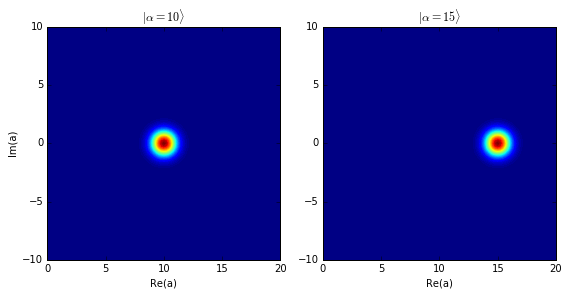

In [4]:
Q1 = myqfunc.qfunc(psi1, areal, aimag, 2)
Q2 = myqfunc.qfunc(psi2, areal, aimag, 2)
plt.figure(figsize=(8, 4))
ax1 = plt.subplot(121)
ax1.contourf(areal, aimag, Q1, 100)
ax1.set_aspect('equal')
plt.xlabel('Re(a)')
plt.ylabel('Im(a)')
plt.title(r'$|\alpha=10\rangle$')

ax2 = plt.subplot(122)
ax2.contourf(areal, aimag, Q2, 100)
ax2.set_aspect('equal')
plt.xlabel('Re(a)')
plt.title(r'$|\alpha=15\rangle$')
plt.tight_layout()

The downside of this approach is that it takes much longer time to calculate the Q function for large photon number (e.g., a few minutes for N = 500).

## Software version

In [5]:
from qutip.ipynbtools import version_table
version_table()

/home/gengyan/anaconda3/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


Software,Version
QuTiP,3.2.0.dev-a521ed9
Numpy,1.10.4
SciPy,0.17.1
matplotlib,1.5.1
Cython,0.24
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,4.2.0
Python,"3.5.1 |Anaconda 2.5.0 (64-bit)| (default, Dec 7 2015, 11:16:01) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
